In [1]:
!pip install pandas
!pip install QuantLib

In [2]:
import pandas as pd
import QuantLib as ql

In [3]:
market_data = [
    ('DEPOSIT', '6M', -0.114),
    ('FRA', '6M', -0.252),
    ('FRA', '12M', -0.306),
    ('SWAP', '2Y', -0.325),
    ('SWAP', '3Y', -0.347)
]

helpers = ql.RateHelperVector()
index = ql.Euribor6M()
for instrument, tenor, rate in market_data:
    rate /= 100
    if instrument == 'DEPOSIT':
        helpers.append(ql.DepositRateHelper(rate, index))
    if instrument == 'FRA':
        monthsToStart = ql.Period(tenor).length()
        helpers.append(ql.FraRateHelper(rate, monthsToStart, index))
    if instrument == 'SWAP':
        helpers.append(
            ql.SwapRateHelper(
                rate,#rate
                ql.Period(tenor),#tenor
                ql.TARGET(),#calendar
                ql.Annual,#fixedFrequency
                ql.Following,#fixedConvention
                ql.Thirty360(ql.Thirty360.BondBasis),#fixedDayCount
                index
            )
        )

params = [2, ql.TARGET(), helpers, ql.Actual360()]
curves = {
    "PiecewiseFlatForward": ql.PiecewiseFlatForward(*params),
    "LogLinearDiscount": ql.PiecewiseLogLinearDiscount(*params),
    "LogCubicDiscount": ql.PiecewiseLogCubicDiscount(*params),
    "LinearZero": ql.PiecewiseLinearZero(*params),
    "CubicZero": ql.PiecewiseCubicZero(*params),
    "LinearForward": ql.PiecewiseLinearForward(*params),
    "SplineCubicDiscount": ql.PiecewiseSplineCubicDiscount(*params)
}


In [4]:
df = pd.DataFrame(index=[row[0] for row in curves['LogLinearDiscount'].nodes()])
print('df len: {}'.format(len(df)))
for curve in curves:
    dfs = [curves[curve].discount(idx) for idx in df.index]
    df[curve] = dfs

display(df)



df len: 6


,PiecewiseFlatForward,LogLinearDiscount,LogCubicDiscount,LinearZero,CubicZero,LinearForward,SplineCubicDiscount
"June 7th, 2023",1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
"December 7th, 2023",1.000580,1.000580,1.000580,1.000580,1.000580,1.000580,1.000580
"June 7th, 2024",1.001863,1.001863,1.001863,1.001863,1.001863,1.001863,1.001863
"December 9th, 2024",1.003441,1.003441,1.003441,1.003441,1.003441,1.003441,1.003441
"June 9th, 2025",1.006546,1.006546,1.006546,1.006546,1.006546,1.006546,1.006546
"June 8th, 2026",1.010485,1.010485,1.010485,1.010485,1.010485,1.010485,1.010485


<Axes: >

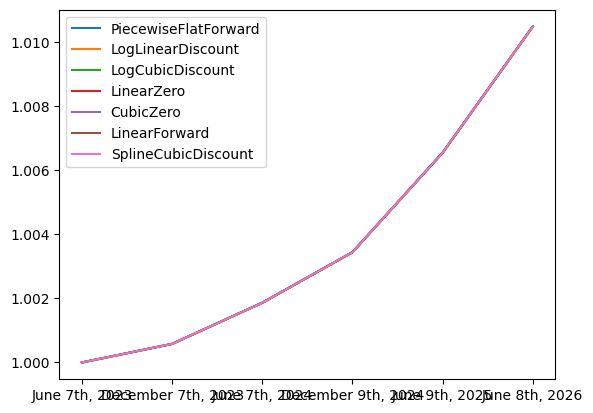

In [5]:
df.plot()

In [6]:
new_df = pd.DataFrame(index=[idx + ql.Period('30d') for idx in df.index])
print('new_df len: {}'.format(len(new_df)))
for curve in curves:
    curves[curve].enableExtrapolation()
    dfs = [curves[curve].discount(idx) for idx in new_df.index]
    new_df[curve] = dfs

display(new_df)


new_df len: 6


,PiecewiseFlatForward,LogLinearDiscount,LogCubicDiscount,LinearZero,CubicZero,LinearForward,SplineCubicDiscount
"July 7th, 2023",1.000095,1.000095,1.000063,1.000095,1.000095,1.000095,1.000063
"January 6th, 2024",1.000790,1.000790,1.000756,1.000742,1.000697,1.000694,1.000756
"July 7th, 2024",1.002119,1.002119,1.002068,1.002090,1.002099,1.002178,1.002067
"January 8th, 2025",1.003952,1.003952,1.003875,1.003885,1.003841,1.003681,1.003875
"July 9th, 2025",1.006870,1.006870,1.007026,1.006853,1.006880,1.007342,1.007026
"July 8th, 2026",1.010811,1.010811,1.010721,1.010829,1.010807,1.010294,1.010721


<Axes: >

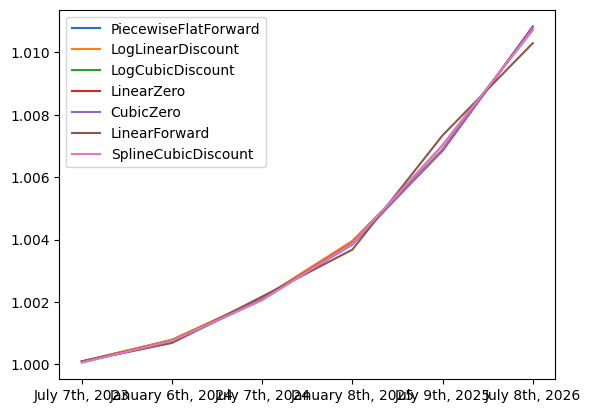

In [7]:
new_df.plot()